# **DNN using PyTorch**

## **1. Fashion MNIST 데이터 셋 알아보기**

### 1-1. Fashion MNIST 데이터 셋

In [1]:
from torchvision import datasets, transforms, utils
from torch.utils import data

import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [3]:
trainset = datasets.FashionMNIST(
    root      = './.data/',
    train     = True,
    download  = True,
    transform = transform
)
testset = datasets.FashionMNIST(
    root      = './.data/',
    train     = False,
    download  = True,
    transform = transform
)

100%|██████████| 26421880/26421880 [00:00<00:00, 119369442.77it/s]


Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 8165350.74it/s]

Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 60119086.94it/s]


Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21943370.93it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



In [4]:
batch_size = 16

train_loader = data.DataLoader(
    dataset     = trainset,
    batch_size  = batch_size
)
test_loader = data.DataLoader(
    dataset     = testset,
    batch_size  = batch_size
)

In [5]:
dataiter       = iter(train_loader)
images, labels = next(dataiter)

### 1-2. 멀리서 살펴보기


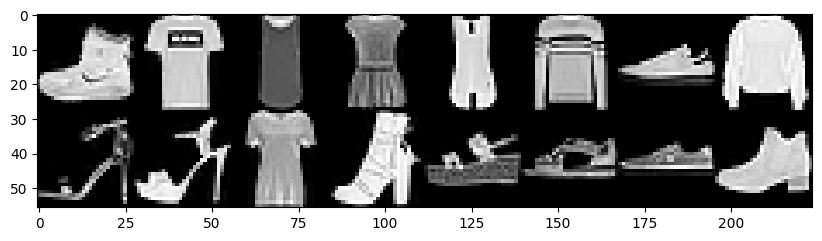

In [6]:
img   = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

In [7]:
print(labels)

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9])


In [8]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}


for label in labels:
    index = label.item()
    print(CLASSES[index])

Ankle boot
T-shirt/top
T-shirt/top
Dress
T-shirt/top
Pullover
Sneaker
Pullover
Sandal
Sandal
T-shirt/top
Ankle boot
Sandal
Sandal
Sneaker
Ankle boot


### 1-3. 가까이서 살펴보기


(28, 28)


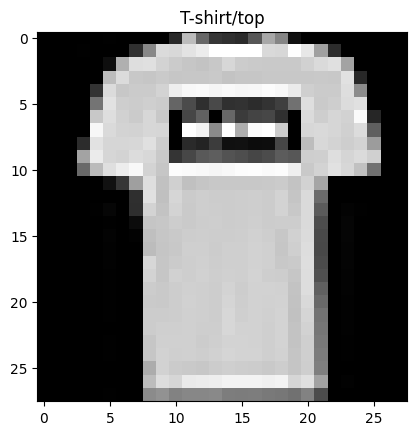

In [9]:
idx = 1

item_img = images[idx]
item_npimg = item_img.squeeze().numpy()
plt.title(CLASSES[labels[idx].item()])
print(item_npimg.shape)
plt.imshow(item_npimg, cmap='gray')
plt.show()

## **2. 인공신경망으로 패션 아이템 분류하기**

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets

In [11]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [12]:
EPOCHS = 30
BATCH_SIZE = 64

### 2-1. 데이터셋 불러오기

In [13]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [14]:
trainset = datasets.FashionMNIST(
    root      = './.data/',
    train     = True,
    download  = True,
    transform = transform
)

testset = datasets.FashionMNIST(
    root      = './.data/',
    train     = False,
    download  = True,
    transform = transform
)

train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
)

test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
)

### 2-2. 신경망으로 Fashion MNIST 학습하기

- 입력 `x` 는 `[배치크기, 색, 높이, 넓이]`로 이루어짐
- `x.size()`는 [64, 1, 28, 28]
- Fashion MNIST에서 이미지의 크기는 28 x 28 (=784), 색은 흑백으로 1 가지
- 사용할 모델은 3개의 레이어를 가진 인공신경망

- 모델 준비
  - `to()` 함수는 모델의 파라미터들을 지정한 곳으로 보내는 역할
  - 일반적으로 CPU 1개만 사용할 경우 필요는 없지만, GPU를 사용하고자 하는 경우 `to("cuda")`로 지정하여 GPU로 보내야 함
  - 지정하지 않을 경우 계속 CPU에 남아 있게 되며 빠른 훈련의 이점을 누리실 수 없음
  - 최적화 알고리즘(Optimizer)으로는 파이토치에 내장되어 있는 `optim.SGD`를 사용

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
model        = Net().to(DEVICE)
optimizer    = optim.SGD(model.parameters(), lr=0.01)

- 학습

In [17]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # 학습 데이터를 DEVICE의 메모리로 보냄
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

- 테스트

In [18]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 모든 오차 더하기
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 큰 값을 가진 클래스가 모델의 예측입니다.
            # 예측과 정답을 비교하여 일치할 경우 correct에 1을 더합니다.
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

- 실행

In [19]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)

    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

[1] Test Loss: 0.8454, Accuracy: 66.67%
[2] Test Loss: 0.7094, Accuracy: 74.48%
[3] Test Loss: 0.5785, Accuracy: 79.48%
[4] Test Loss: 0.5407, Accuracy: 80.90%
[5] Test Loss: 0.5090, Accuracy: 82.10%
[6] Test Loss: 0.4946, Accuracy: 82.54%
[7] Test Loss: 0.4906, Accuracy: 82.54%
[8] Test Loss: 0.4773, Accuracy: 83.02%
[9] Test Loss: 0.4575, Accuracy: 83.55%
[10] Test Loss: 0.4638, Accuracy: 83.55%
[11] Test Loss: 0.4509, Accuracy: 84.11%
[12] Test Loss: 0.4568, Accuracy: 84.05%
[13] Test Loss: 0.4447, Accuracy: 84.54%
[14] Test Loss: 0.4240, Accuracy: 84.97%
[15] Test Loss: 0.4300, Accuracy: 84.78%
[16] Test Loss: 0.4220, Accuracy: 85.21%
[17] Test Loss: 0.4233, Accuracy: 85.02%
[18] Test Loss: 0.4091, Accuracy: 85.55%
[19] Test Loss: 0.4034, Accuracy: 85.56%
[20] Test Loss: 0.4052, Accuracy: 85.67%
[21] Test Loss: 0.3949, Accuracy: 86.11%
[22] Test Loss: 0.4050, Accuracy: 85.62%
[23] Test Loss: 0.4086, Accuracy: 85.32%
[24] Test Loss: 0.3876, Accuracy: 86.29%
[25] Test Loss: 0.3872, A

## **3. 과적합과 정규화**

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets

In [21]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [22]:
EPOCHS = 50
BATCH_SIZE = 64

### 3-1. 데이터셋에 노이즈 추가

original.png

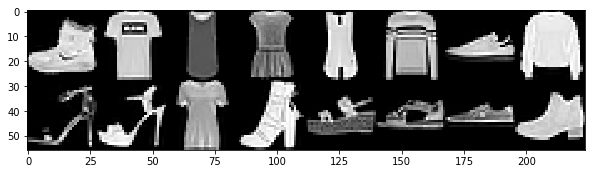

horizontalflip.png

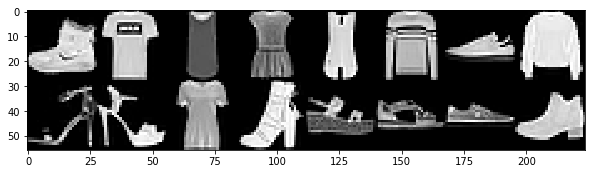

In [23]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./.data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./.data',
                   train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

### 3-2. 신경망으로 Fashion MNIST 학습

- 모델 준비

In [24]:
class Net(nn.Module):
    def __init__(self, dropout_p=0.2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        # 드롭아웃 확률
        self.dropout_p = dropout_p

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        # 드롭아웃 추가
        x = F.dropout(x, training=self.training,
                      p=self.dropout_p)
        x = F.relu(self.fc2(x))
        # 드롭아웃 추가
        x = F.dropout(x, training=self.training,
                      p=self.dropout_p)
        x = self.fc3(x)
        return x

In [25]:
model        = Net(dropout_p=0.2).to(DEVICE)
optimizer    = optim.SGD(model.parameters(), lr=0.01)

- 학습

In [26]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

- 테스트


In [27]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 맞춘 갯수 계산
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

- 실행

In [28]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)

    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

[1] Test Loss: 0.6545, Accuracy: 76.75%
[2] Test Loss: 0.5439, Accuracy: 80.22%
[3] Test Loss: 0.4983, Accuracy: 81.87%
[4] Test Loss: 0.4754, Accuracy: 82.49%
[5] Test Loss: 0.4415, Accuracy: 84.11%
[6] Test Loss: 0.4349, Accuracy: 84.36%
[7] Test Loss: 0.4237, Accuracy: 84.57%
[8] Test Loss: 0.4076, Accuracy: 85.29%
[9] Test Loss: 0.4048, Accuracy: 85.32%
[10] Test Loss: 0.3932, Accuracy: 85.96%
[11] Test Loss: 0.3901, Accuracy: 86.07%
[12] Test Loss: 0.3814, Accuracy: 86.33%
[13] Test Loss: 0.3746, Accuracy: 86.61%
[14] Test Loss: 0.3786, Accuracy: 86.42%
[15] Test Loss: 0.3681, Accuracy: 86.85%
[16] Test Loss: 0.3654, Accuracy: 86.88%
[17] Test Loss: 0.3610, Accuracy: 86.99%
[18] Test Loss: 0.3675, Accuracy: 86.69%
[19] Test Loss: 0.3595, Accuracy: 87.18%
[20] Test Loss: 0.3524, Accuracy: 87.04%
[21] Test Loss: 0.3507, Accuracy: 87.34%
[22] Test Loss: 0.3470, Accuracy: 87.62%
[23] Test Loss: 0.3505, Accuracy: 87.34%
[24] Test Loss: 0.3403, Accuracy: 87.77%
[25] Test Loss: 0.3371, A